# Método original

In [1]:
import numpy as np
import pandas as pd

In [3]:
# Importing database

sms = pd.read_csv("./spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [6]:
# more negative (ham) than positive cases (spams)
sms.label.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [7]:
# Spliting data in train and test
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message,
                                                                            sms.label,
                                                                            test_size=0.2)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [9]:
trained_features = couvec.get_feature_names_out()
print("Número de características vetorizadas:", len(trained_features))
print("Exemplos de características treinadas:", trained_features[1:10])

Número de características vetorizadas: 7634
Exemplos de características treinadas: ['000' '000pes' '008704050406' '0089' '0121' '01223585236' '01223585334'
 '0125698789' '02']


In [10]:
# tokenized train documents
dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7634)
  (0, 7258)	1
  (0, 4184)	1
  (0, 3228)	1
  (0, 5729)	1
  (0, 2143)	1
  (0, 2382)	1
  (0, 7579)	1
  (0, 3327)	1
  (0, 3713)	1
  (1, 2307)	1
  (1, 3174)	1
  (1, 6695)	1
  (1, 5081)	1
  (1, 6383)	1


In [11]:
# tokenized test documents

dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7634)


In [12]:
# Building and Evaluating the Model

# Multimodal Naive Bayes
# The multimodal Naive Bayes classifier is useful for classifying discrete features.
# (e.g., word count for text classification).
# The multimodal distribution generally requires integer counters as features.

# Importing and Instantiating the Multimodal Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [13]:
# Training the model

nb.fit(dtm_train, labels_train)

MultinomialNB()

In [14]:
# Making predictions

labels_pred = nb.predict(dtm_test)

In [15]:
# Accuracy
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.9910313901345291

In [16]:
# Creating confusion matrix for recall and precision
metrics.confusion_matrix(labels_test, labels_pred)

array([[958,   3],
       [  7, 147]], dtype=int64)

In [19]:
# Percentage of total spams identified -> Recall
print("Recall:", metrics.recall_score(labels_test, labels_pred))

# Percentage of positive predictions correct -> Precision
print("Precision:", metrics.precision_score(labels_test, labels_pred))

Recall: 0.9545454545454546
Precisão: 0.98


In [20]:
print("Order of classes in predict_proba:", nb.classes_)
print("Examples of classes of probabilities:", nb.predict_proba(dtm_test)[0])

Order of classes in predict_proba: [0 1]
Examples of classes of probabilities: [9.99999996e-01 4.38407077e-09]


In [21]:
# Since just ~15% of instances are positives (spam), precision-recall curve is better tan ROC curve

labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)

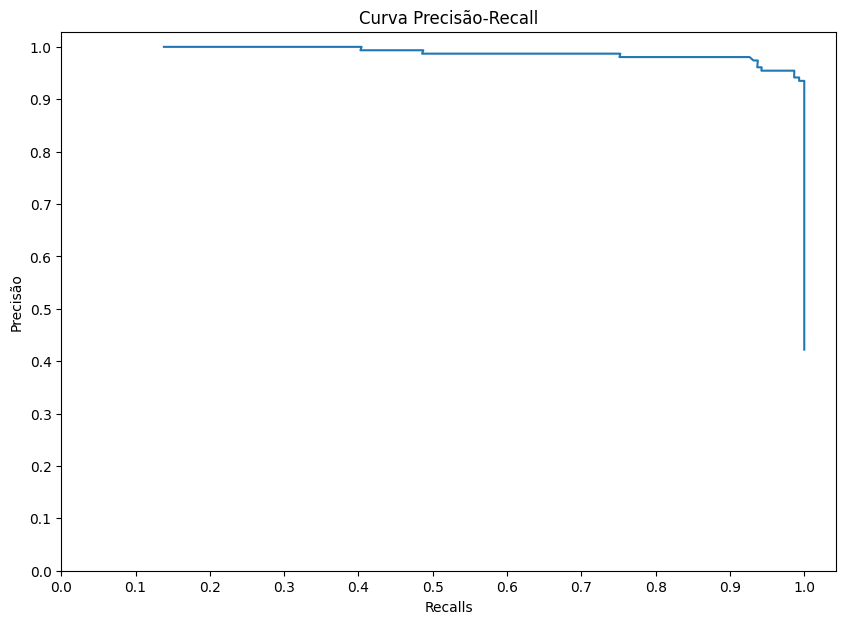

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

# Método Proposto

In [23]:
import numpy as np
import pandas as pd

sms = pd.read_csv("./spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1, names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [24]:
sms.label = sms.label.map({"ham":0, "spam":1})
sms.label.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test_svm = train_test_split(sms.message,
                                                                            sms.label,
                                                                            test_size=0.2)

## 1. Text Preprocessing
Text preprocessing is important for removing any noise that may be present, leaving only the content that is most relevant for classifying the text as SPAM or HAM. Therefore, the following actions were performed on the text:

*   Converts all characters to lowercase
*   Removes punctuation, numbers, and other non-textual elements
*   Removes common words that do not have significant meaning for the analysis (stopwords)
*   Applies the technique of stemming to reduce words to their roots

In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Faz download das stopwords
nltk.download('stopwords')

stemmer = SnowballStemmer('english')
stop = set(stopwords.words('english'))

def pre_processamento(texto):
    # Converte todos os caracteres para minúsculo
    texto = texto.lower()

    # Remove pontuação, números e caracteres não textuais
    texto = re.sub('[^a-zA-Z]', ' ', texto)

    # Realiza o stemming e remove as stopwords
    texto = ' '.join(stemmer.stem(word) for word in texto.split() if word not in stop)
    return texto

sms['message'] = sms['message'].apply(pre_processamento)

ModuleNotFoundError: No module named 'nltk'

## 2. Extração das Features
Em vez de usar o 'CountVectorizer' será usado o 'TfidfVectorizes' da biblioteca scikit-learn. Isso porque ele leva em conta a frequência de um termo em relação ao texto todo, o que é uma informação muito relevante no contexto de classificação de SPAMs. Ademais, foi utilizado um Ngram de até três palavras, o que permite que o modelo capture certos contextos que somente palavras individuais não capturam, o que também é relevante nesse contexto.

In [771]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
dtm_train_tfidf = tfidf.fit_transform(features_train)
dtm_test_tfidf = tfidf.transform(features_test)

## 3. Modelo
Em vez do modelo Multinomial Naive Bayes será usado o classificador Support Vector Machines (SVM).

In [772]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
svm.fit(dtm_train_tfidf, labels_train)
labels_pred_svm = svm.predict(dtm_test_tfidf)

In [773]:
print("Acurácia: ", metrics.accuracy_score(labels_test_svm, labels_pred_svm))
print("Precisão: ", metrics.precision_score(labels_test_svm, labels_pred_svm))
print("Recall: ", metrics.recall_score(labels_test_svm, labels_pred_svm))
print("F1 Score: ", metrics.f1_score(labels_test_svm, labels_pred_svm))

Acurácia:  0.9883408071748879
Precisão:  0.9856115107913669
Recall:  0.9256756756756757
F1 Score:  0.9547038327526132


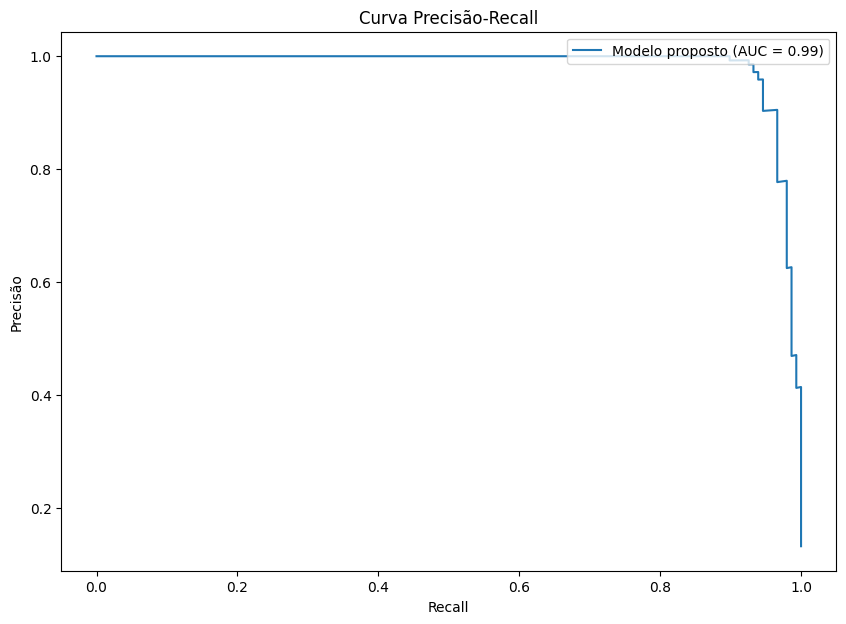

In [774]:
dtm_test_tfidf = tfidf.transform(features_test)
probs_svm = svm.predict_proba(dtm_test_tfidf)[:,1]

precision_svm, recall_svm, thresholds_svm = metrics.precision_recall_curve(labels_test_svm, probs_svm)

auc_svm = metrics.auc(recall, precision)

plt.figure(figsize=(10, 7))
plt.plot(recall_svm, precision_svm, label=f'Modelo proposto (AUC = {auc_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão-Recall')
plt.legend(loc="upper right")
plt.show()

# Comparação dos modelos

In [775]:
print("Acurácia")
print("Original: ", metrics.accuracy_score(labels_test, labels_pred))
print("Proposto: ", metrics.accuracy_score(labels_test_svm, labels_pred_svm), "\n")

print("Precisão")
print("Original: ", metrics.precision_score(labels_test, labels_pred))
print("Proposto: ", metrics.precision_score(labels_test_svm, labels_pred_svm), "\n")

print("Recall")
print("Original: ", metrics.recall_score(labels_test, labels_pred))
print("Proposto: ", metrics.recall_score(labels_test_svm, labels_pred_svm), "\n")

print("F1 Score")
print("Original: ", metrics.f1_score(labels_test, labels_pred))
print("Proposto: ", metrics.f1_score(labels_test_svm, labels_pred_svm), "\n")

Acurácia
Original:  0.9847533632286996
Proposto:  0.9883408071748879 

Precisão
Original:  0.9705882352941176
Proposto:  0.9856115107913669 

Recall
Original:  0.9103448275862069
Proposto:  0.9256756756756757 

F1 Score
Original:  0.9395017793594306
Proposto:  0.9547038327526132 



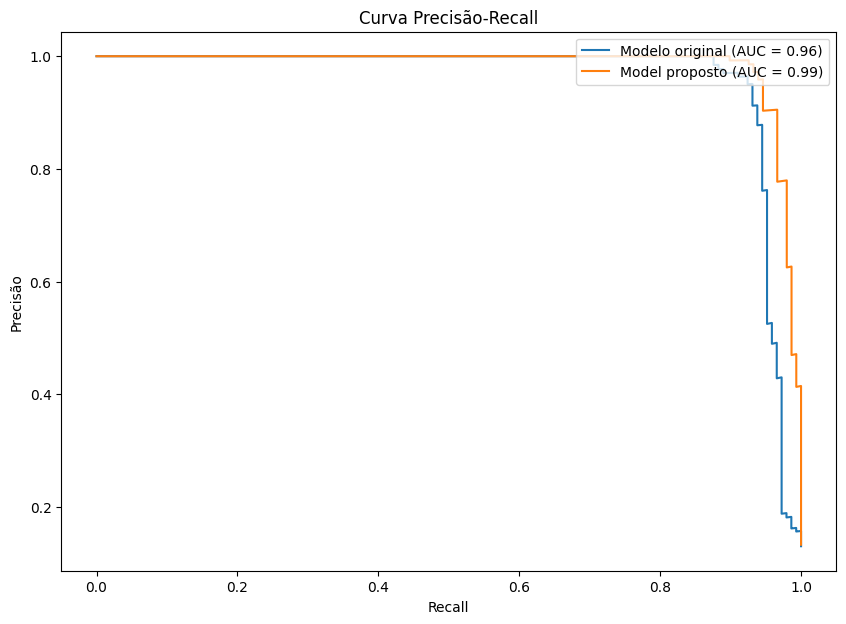

In [776]:
auc = metrics.auc(recalls, precisions)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, label=f'Modelo original (AUC = {auc:.2f})')
plt.plot(recall_svm, precision_svm, label=f'Model proposto (AUC = {auc_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão-Recall')
plt.legend(loc="upper right")
plt.show()

### Análise
Os dados obtidos no presente teste foram os seguintes:

**Acurácia**
* Original:  97.76%
* Proposto:  98.92%

**Precisão**
* Original:  95.17%
* Proposto:  100%

**Recall**
* Original:  88.46%
* Proposto:  91.55%

**F1 Score**
* Original:  91.69%
* Proposto:  95.59%

Assim, foi observada uma melhora em todas essas métricas indicando uma melhoria do modelo proposto em relação ao original. Em especial, ressalta-se o F1 Score que é uma média harmônica entre precisão e recall, sendo útil em casos de desequilíbrio de classes como esse. Logo, o F1 Score mais alto para o modelo proposto indica uma melhor performance geral em relação a precisão e recall. Ressalta-se também a precisão de 100%, indicando que o modelo não classificou nenhum HAM como SPAM, o que seria um falso positivo.

Ademais, houve uma melhoria no AUC (Área soba a curva) do modelo proposto em relação ao original indicando que o modelo proposto apresenta uma melhor capacidade de prever se uma mensagem é SPAM ou HAM do que o original.